<a href="https://colab.research.google.com/github/jasminjahanpuspo/MS_Thesis/blob/main/BM_S_Dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Step 1: Setup Environment

##### 🔹 Mount Google Drive
*   Access datasets stored in your Google Drive.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### 🔹 Import Required Libraries
*   First: Load all necessary libraries for image processing, data handling, and visualization.
*   Second: Load TensorFlow, Keras, and layers for building CNN models.

In [2]:
# -------------------- Libraries for Data Handling -------------------- #
import numpy as np              # Numerical operations and arrays
import pandas as pd             # Data manipulation and analysis
import os                       # File and directory operations
import glob as gb               # File pattern matching (e.g., get all image paths)

# -------------------- Libraries for Image Processing ---------------- #
import cv2                      # OpenCV for image reading, processing, and augmentation

# -------------------- Libraries for Visualization ------------------ #
import matplotlib.pyplot as plt # Plotting graphs and images
import seaborn as sns           # Advanced visualizations (heatmaps, pairplots)
%matplotlib inline
import matplotlib

from PIL import Image
import random
import math

import shutil
from tqdm import tqdm

from PIL import Image
from scipy.ndimage import gaussian_filter

In [3]:
# -------------------- TensorFlow & Keras -------------------- #
import tensorflow as tf                       # Core TensorFlow library
from tensorflow import keras                  # High-level API for building neural networks
from tensorflow.keras.preprocessing import image


# -------------------- Dataset Utilities -------------------- #
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Load images from directories into TensorFlow datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras import layers, models
# -------------------- Layers for CNN Models ---------------- #
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

# 📌 Step 2: Dataset Import or Extraction
* This step ensures the dataset is clean, balanced, and standardized.
  

##### 🔹 Option 1: Upload & Unzip from Local Drive

In [ ]:
# Unzip dataset from Drive
import zipfile
zip_path = "/content/drive/MyDrive/dataset.zip"  # Change to your file path
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset successfully unzipped to:", extract_path)


##### 🔹 Option 2: Download & Extract from Kaggle

In [ ]:
# Install Kaggle API (if not already installed)
!pip install -q kaggle

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Choose kaggle.json from your local machine

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Example: Download dataset from Kaggle
!kaggle datasets download -d jasminpuspo/bengali-taka

# Unzip the downloaded file
import zipfile
with zipfile.ZipFile("bengali-taka.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/bengali_taka")

print("✅ Kaggle dataset downloaded and extracted successfully!")


##### 🔹 Option 3: Download from Any Public URL

In [ ]:
import requests, zipfile, io

# Example: download dataset from a direct URL
url = "https://example.com/dataset.zip"
extract_path = "/content/external_dataset"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset downloaded and extracted from:", url)


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nsojib/bangla-money")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bangla-money' dataset.
Path to dataset files: /kaggle/input/bangla-money


##### 🔹 Move Extracted Dataset to Drive

In [8]:
!cp -r /kaggle/input/bangla-money /content/drive/MyDrive/Bengali_Taka/BM_S

# 📌 Step 3: Visualize Original Dataset
* This step ensures the dataset is clean, balanced, and standardized.
  

##### 🔹 **Root folder & Subfolder**  
* Set the dataset `root folder` and detect all class `subfolders` as class names.


In [12]:
root_folder = '/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training'  # <-- change this path
class_names = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
print('Classes found:', class_names)

Classes found: ['500', '2', '10', '20', '5', '1000', '100', '50', '1']


##### 🔹 **Count**  
* Count the number of images in each class.


In [13]:
# Count images in each class
image_counts = {cls: len(os.listdir(os.path.join(root_folder, cls))) for cls in class_names}

# Print dataset structure
for cls in class_names:
    print(f"Class '{cls}' contains {image_counts[cls]} images")

Class '500' contains 137 images
Class '2' contains 214 images
Class '10' contains 214 images
Class '20' contains 174 images
Class '5' contains 214 images
Class '1000' contains 168 images
Class '100' contains 209 images
Class '50' contains 214 images
Class '1' contains 102 images


##### 🔹 **Visualize Distribution**  
Plot a bar chart to show the number of images per class and check for imbalance.

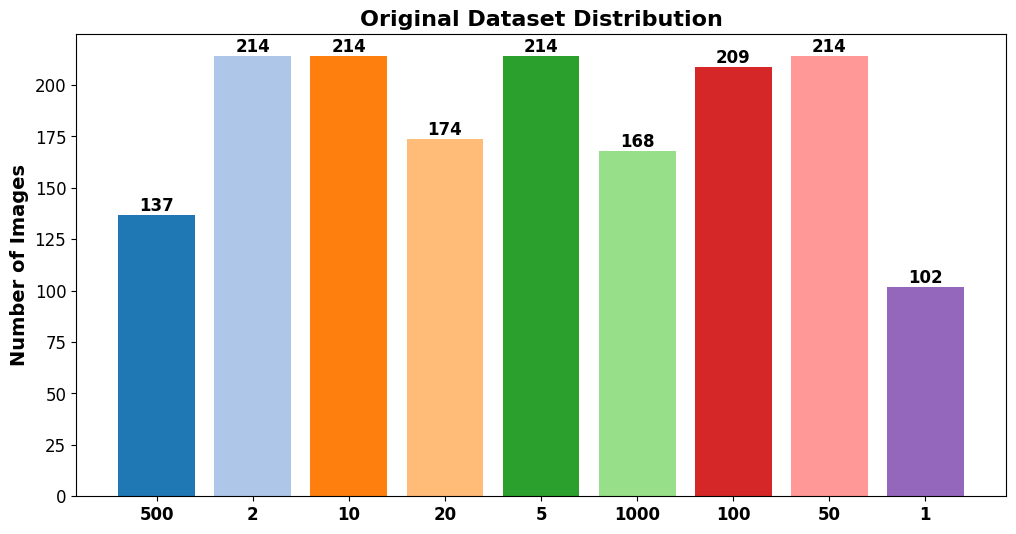

In [16]:
# Example: image_counts is a dictionary {class_name: count}
plt.figure(figsize=(12, 6))

# Generate a list of colors automatically
colors = plt.cm.tab20(range(len(image_counts)))  # tab20 gives 20 distinct colors

bars = plt.bar(image_counts.keys(), image_counts.values(), color=colors)

# Titles and labels with bold fonts
plt.title('Original Dataset Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom',
        fontsize=12, fontweight='bold', color='black'
    )

plt.show()


##### 🔹 **Rename**
* Rename all images in each class as `classname_ID.extension`.

In [15]:
print("Renaming images sequentially in each class...")

for cls in os.listdir(root_folder):
    class_path = os.path.join(root_folder, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for idx, img_name in enumerate(images, start=1):
            old_path = os.path.join(class_path, img_name)

            # New name: classname_1.jpg, classname_2.jpg, ...
            new_name = f"{cls}_{idx}.jpg"
            new_path = os.path.join(class_path, new_name)

            os.rename(old_path, new_path)

print("✅ All images renamed sequentially.")

Renaming images sequentially in each class...
✅ All images renamed sequentially.


Display random samples from each class with captions.

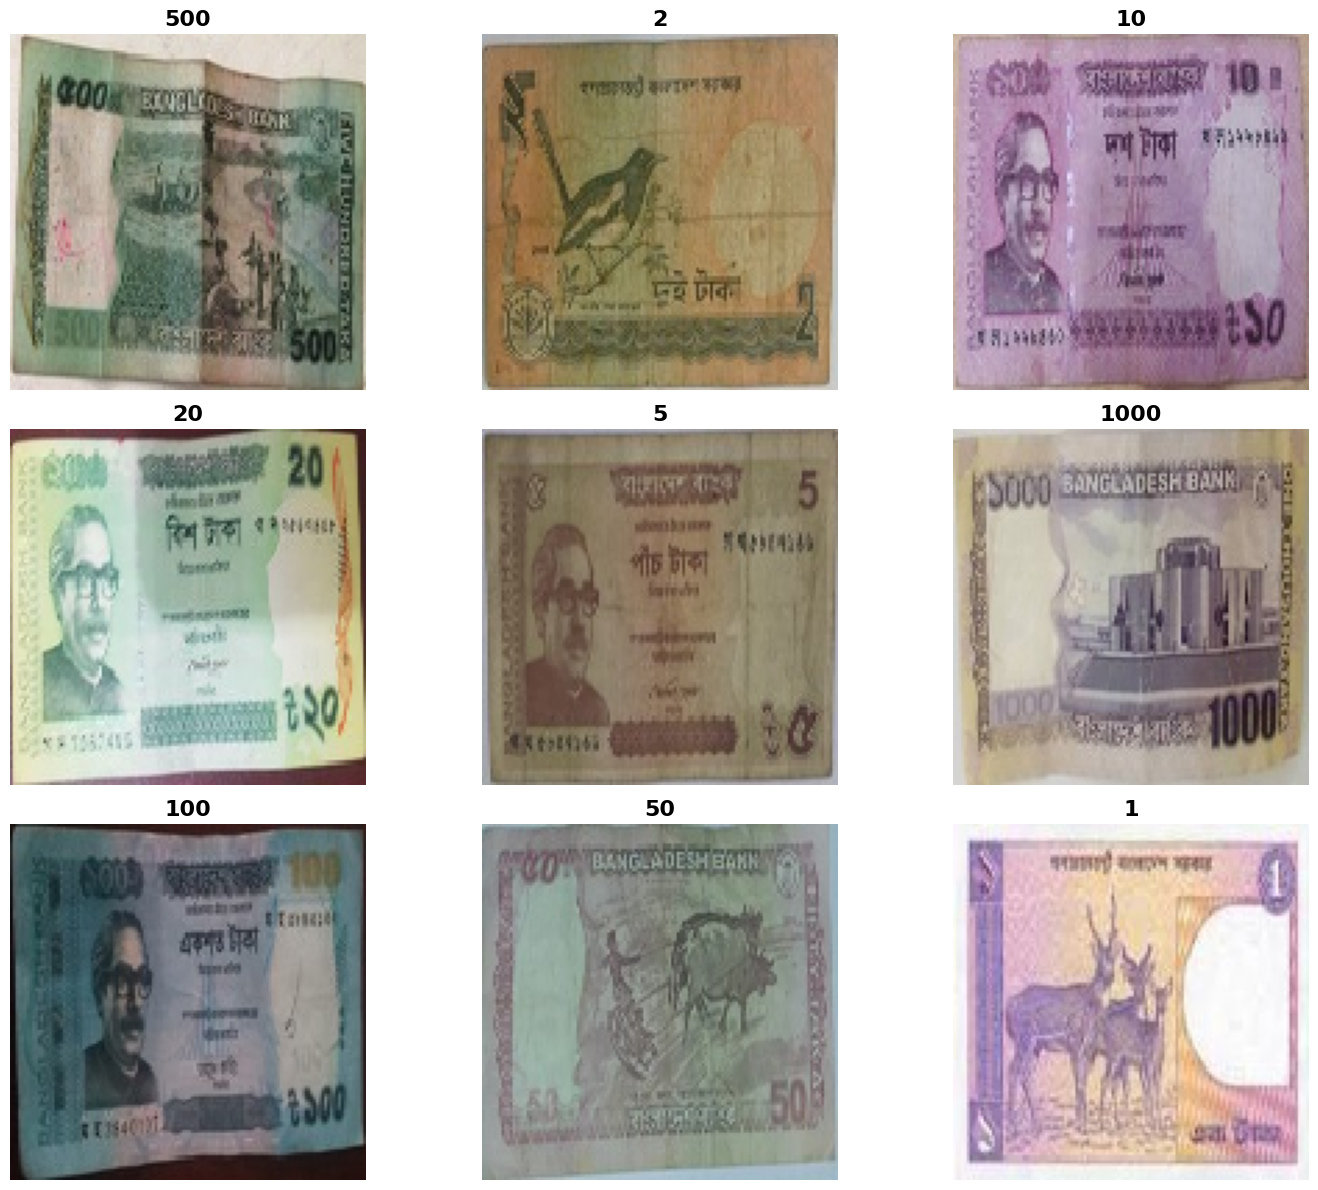

In [17]:
# Auto set columns (max 3 per row for readability)
n_classes = len(class_names)
cols = min(3, n_classes)              # at most 3 columns
rows = math.ceil(n_classes / cols)    # rows adjust automatically

plt.figure(figsize=(5*cols, 4*rows))  # scale figure size to layout

for i, cls in enumerate(class_names):
    images = os.listdir(os.path.join(root_folder, cls))
    sample_img = random.choice(images)
    img_path = os.path.join(root_folder, cls, sample_img)
    img = load_img(img_path, target_size=(128,128))

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(cls, fontsize=16, fontweight='bold')  # bold caption
    plt.axis('off')

plt.tight_layout()
plt.show()


##### 🔹 **Resize**
* Check all image size.
* Resize all images to `224×224` or `299*299` pixels for consistency in training.
* Plot the original and resize image for comparison.

In [18]:
dataset_path = root_folder  # change if needed

# Collect all unique image sizes
image_sizes = set()

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                h, w, c = img.shape
                image_sizes.add((w, h, c))

# Show results
if len(image_sizes) == 1:
    print(f"✅ All images have the same size: {list(image_sizes)[0]} (Width x Height x Channels)")
else:
    print("⚠️ Found multiple image sizes in the dataset:")
    for size in image_sizes:
        print(f"   {size} (Width x Height x Channels)")


✅ All images have the same size: (250, 120, 3) (Width x Height x Channels)


In [19]:
# Root folder with subfolders per class
dataset_path = root_folder
target_size = (224, 224)  # width, height

print("Resizing all images to 224x224...")

for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Read image
            img = cv2.imread(img_path)
            if img is not None:
                # Resize
                resized_img = cv2.resize(img, target_size)
                # Overwrite the original image with resized one
                cv2.imwrite(img_path, resized_img)

print("✅ All images resized to 224x224.")


Resizing all images to 224x224...
✅ All images resized to 224x224.


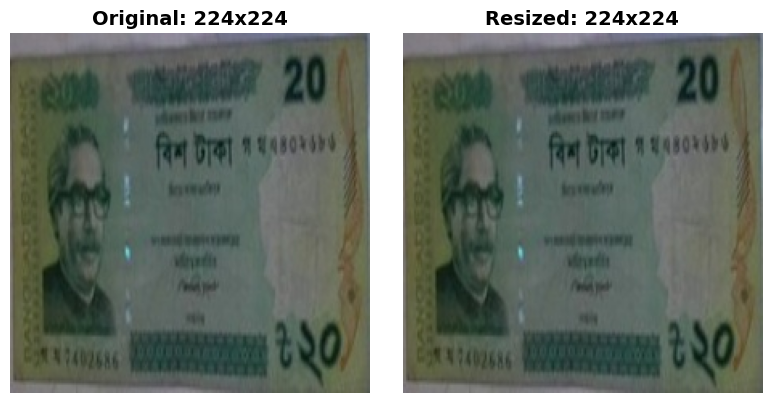

In [20]:
# Select any class and one image
classes = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
selected_class = random.choice(classes)
img_name = random.choice(os.listdir(os.path.join(root_folder, selected_class)))
img_path = os.path.join(root_folder, selected_class, img_name)

# Read original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_size = original_img.shape[:2]  # height, width

# Resize image
target_size = (224, 224)
resized_img = cv2.resize(original_img, target_size)
resized_size = resized_img.shape[:2]  # height, width

# Plot original vs resized with sizes in title
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title(f'Original: {original_size[1]}x{original_size[0]}', fontsize=14, fontweight='bold')  # width x height
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(resized_img)
plt.title(f'Resized: {resized_size[1]}x{resized_size[0]}', fontsize=14, fontweight='bold')  # width x height
plt.axis('off')

plt.tight_layout()
plt.show()


# 📌 Step 4: Split Dataset into Train, Validation, and Test

##### 🔹 **Split Dataset**  
- Divide images into Train, Validation, and Test sets (.g., `70:15:15` or `80:10:10`).  
- Create new directories and copy images into the respective folders.



In [21]:
# Original dataset path (with subfolders per class)
original_dataset = root_folder  # your root folder

# Path to split folder (will be created under the root folder)
split_dataset = os.path.join(root_folder, "split")

# Remove previous split folder if it exists
if os.path.exists(split_dataset):
    shutil.rmtree(split_dataset)

# Create new split folder
os.makedirs(split_dataset)

# Split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

print("🔄 Splitting dataset into train/val/test...")

# Iterate only over actual class folders (ignore any existing 'split' folder)
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_path) or class_name == "split":
        continue  # skip non-folders and split folder itself

    # List all files in the class folder
    imgs = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(imgs)

    n_total = len(imgs)
    n_train = math.floor(train_ratio * n_total)
    n_val   = math.floor(val_ratio * n_total)

    split_imgs = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    # Copy images to their respective split folders
    for split, files in split_imgs.items():
        split_class_path = os.path.join(split_dataset, split, class_name)
        os.makedirs(split_class_path, exist_ok=True)

        for f in tqdm(files, desc=f"{class_name}-{split}"):
            src_path = os.path.join(class_path, f)
            dst_path = os.path.join(split_class_path, f)
            shutil.copy2(src_path, dst_path)  # copy file, preserve metadata

print("✅ Dataset successfully split into train/val/test at:", split_dataset)


🔄 Splitting dataset into train/val/test...


1-test: 100%|██████████| 5/5 [00:00<00:00, 73.28it/s]

✅ Dataset successfully split into train/val/test at: /content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training/split


##### 🔹 **Visualize Splits**  
* Plot a **pie chart** showing the proportion of images in Train, Validation, and Test sets.


In [22]:
# Print counts per folder
print("\n📊 Dataset distribution after splitting:")
for split in ["train", "val", "test"]:
    total = 0
    print(f"\n{split.upper()}:")
    split_path = os.path.join(split_dataset, split)
    for class_name in os.listdir(split_path):
        count = len(os.listdir(os.path.join(split_path, class_name)))
        total += count
        print(f"   {class_name}: {count}")
    print(f"   Total {split}: {total}")


📊 Dataset distribution after splitting:

TRAIN:
   500: 56
   2: 86
   10: 86
   20: 69
   5: 87
   1000: 71
   100: 84
   50: 89
   1: 36
   Total train: 664

VAL:
   500: 7
   2: 10
   10: 10
   20: 8
   5: 10
   1000: 8
   100: 10
   50: 11
   1: 4
   Total val: 78

TEST:
   500: 8
   2: 12
   10: 12
   20: 10
   5: 12
   1000: 10
   100: 12
   50: 12
   1: 5
   Total test: 93


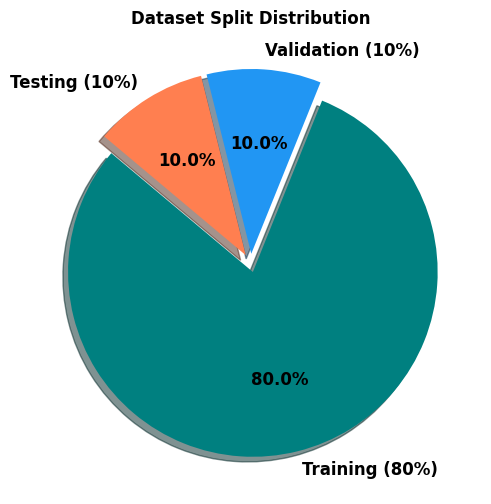

In [24]:
# Data for the pie chart
#labels = ['Training (70%)', 'Validation (20%)', 'Testing (10%)']
#sizes = [70, 20, 10]

labels = ['Training (80%)', 'Validation (10%)', 'Testing (10%)']
sizes= [80,10,10]

colors = ['teal', '#2196F3', 'coral' ]  # Green, Blue, Orange
explode = (0.05, 0.05, 0.05)  # Slightly separate each section

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Dataset Split Distribution', fontweight='bold')
plt.show()


##### 🔹 **Folder Structure**  
Visualize the directory structure of the split dataset to verify class organization.


```text
root_folder/
├── train/
│   ├── class_1/
│   └── class_2/
├── validation/
│   ├── class_1/
│   └── class_2/
└── test/
    ├── class_1/
    └── class_2/


# 📌 Step 5: Augment Training Data


##### 🔹 **Apply Augmentations**  
* Perform image augmentations such as rotation, shift, zoom, flip, and shear.
* Save augmented images in a separate folder: `aug_train/`.
*  Count the number of images per class after augmentation.


In [28]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Paths
train_path = os.path.join(split_dataset, 'train')
aug_root = os.path.join(original_dataset, 'aug_train')
os.makedirs(aug_root, exist_ok=True)

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Allowed image extensions
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

# Loop through each class folder
for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    aug_cls_path = os.path.join(aug_root, cls)
    os.makedirs(aug_cls_path, exist_ok=True)

    original_images = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_exts)]
    n_original = len(original_images)
    n_aug_per_img = 3  # 3 augmentations per image

    print(f"Augmenting class '{cls}': {n_original} originals → {n_original * n_aug_per_img} augmented images total")

    # Augment each image
    for img_name in original_images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=aug_cls_path,
                                      save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= n_aug_per_img:  # stop after 3 augmentations per image
                    break

        except Exception as e:
            print(f"⚠️ Skipped '{img_name}' due to error: {e}")


Augmenting class '500': 56 originals → 168 augmented images total
⚠️ Skipped '500_57.jpg' due to error: cannot identify image file <_io.BytesIO object at 0x7ac1fad016c0>
Augmenting class '2': 86 originals → 258 augmented images total
⚠️ Skipped '2_204.jpg' due to error: cannot identify image file <_io.BytesIO object at 0x7ac1fad01080>
Augmenting class '10': 86 originals → 258 augmented images total
Augmenting class '20': 69 originals → 207 augmented images total
⚠️ Skipped '20_161.jpg' due to error: cannot identify image file <_io.BytesIO object at 0x7ac1fad01210>
Augmenting class '5': 87 originals → 261 augmented images total
⚠️ Skipped '5_210.jpg' due to error: cannot identify image file <_io.BytesIO object at 0x7ac1fad016c0>
Augmenting class '1000': 71 originals → 213 augmented images total
⚠️ Skipped '1000_157.jpg' due to error: cannot identify image file <_io.BytesIO object at 0x7ac1fad01080>
Augmenting class '100': 84 originals → 252 augmented images total
⚠️ Skipped '100_159.jpg

##### 🔹 **Visualize Distribution**  
* Plot a **bar chart** comparing class balance **before and after** augmentation.  

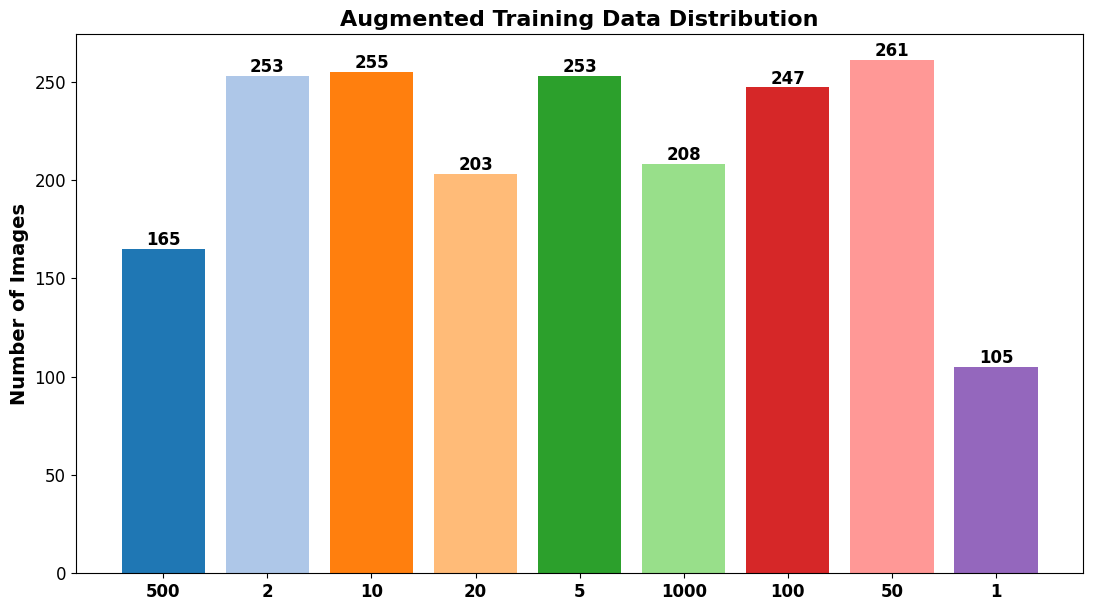

In [30]:
# Count images in augmented train folders
aug_counts = {cls: len(os.listdir(os.path.join(aug_root, cls))) for cls in class_names}

plt.figure(figsize=(13,7))

# Generate distinct colors for each bar
colors = plt.cm.tab20(np.arange(len(aug_counts)))

bars = plt.bar(aug_counts.keys(), aug_counts.values(), color=colors)

plt.title('Augmented Training Data Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # X position (center of the bar)
        height,                              # Y position (top of the bar)
        f'{int(height)}',                    # The text (convert to int)
        ha='center', va='bottom',            # Centered alignment
        fontsize=12, fontweight='bold', color='black'
    )

plt.show()

# 📌 Step 6: Comparison Section

##### 🔹 **Compare Counts**  
* Compare the number of images in the original Train set versus the augmented Train set.
* **Visualize differences** in dataset size across classes.  
* Ensure **uniform class balance** after augmentation.


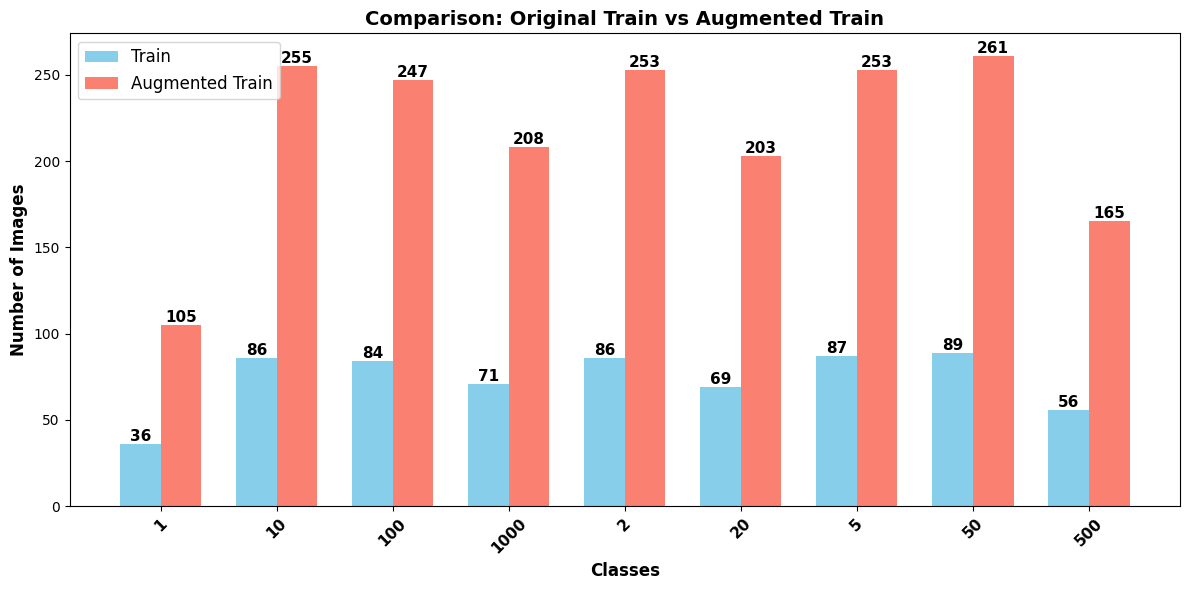

In [31]:
# Paths
train_folder = os.path.join(split_dataset, "train")  # original train split
aug_folder   = os.path.join(root_folder, "aug_train")  # augmented train folder

# Get list of classes (assumes both folders have same class names)
classes = sorted([c for c in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, c))])

# Count images per class
train_counts = [len(os.listdir(os.path.join(train_folder, c))) for c in classes]
aug_counts   = [len(os.listdir(os.path.join(aug_folder, c))) for c in classes]

# Plot side-by-side bar chart
x = np.arange(len(classes))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
rects2 = ax.bar(x + width/2, aug_counts, width, label='Augmented Train', color='salmon')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_title('Comparison: Original Train vs Augmented Train', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, fontsize=11, fontweight='bold')
ax.legend(fontsize=12)

# Add number labels on each bar
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width()/2, height,
            f'{int(height)}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold', color='black'
        )

plt.tight_layout()
plt.show()


# 📌 Step 7: Denoise Training Data Only

##### 🔹 **Denoising**  
* Apply filters like **Median or Gaussian** to reduce image noise.  

In [32]:
from tqdm import tqdm

# Path to augmented training images
aug_root = os.path.join(root_folder, "aug_train")  # your aug_train folder

print("🔄 Denoising augmented images...")

# Loop through each class subfolder
for cls in os.listdir(aug_root):
    class_path = os.path.join(aug_root, cls)
    if not os.path.isdir(class_path):
        continue  # skip non-folder files

    # Loop through each image file in the class folder
    for img_name in tqdm(os.listdir(class_path), desc=f"Filtering {cls}"):
        img_path = os.path.join(class_path, img_name)

        # Read the image
        img = cv2.imread(img_path)

        if img is not None:
            try:
                # Apply median filter (kernel size = 3 or 5)
                filtered = cv2.medianBlur(img, 3)

                # Overwrite the original image
                cv2.imwrite(img_path, filtered)

            except Exception as e:
                print(f"⚠️ Skipped {img_name} due to error: {e}")
        else:
            print(f"⚠️ Skipped {img_name}: cannot read image")

print("✅ All augmented images successfully filtered and originals replaced.")


🔄 Denoising augmented images...


Filtering 1: 100%|██████████| 105/105 [00:01<00:00, 72.03it/s]

✅ All augmented images successfully filtered and originals replaced.


##### 🔹 **Save Images**  
* Store denoised images in the same training data folder.

In [ ]:
# Path to augmented images
aug_root = os.path.join(root_folder, "aug_train")  # your augmented folder

# Choose a random class and image
cls = random.choice([c for c in os.listdir(aug_root) if os.path.isdir(os.path.join(aug_root, c))])
class_path = os.path.join(aug_root, cls)
img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

# Read original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Apply denoising (for demonstration)
denoised_img = cv2.fastNlMeansDenoisingColored(original_img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

# Plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title(f"Original: {cls}/{img_name}", fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(denoised_img)
plt.title(f"Denoised: {cls}/{img_name}", fontsize=12, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()
